# Relax and Hold Steady

## Poisson Equation

Poisson's equation involves imposed values inside the field (a.k.a., sources): 

$$
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b
$$



In discretized form, it looks almost the same as the Laplace equation, except for the source term on the right-hand side: 

$$
\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}=b_{i,j}^{k}
$$

Rearranging to obtain an equation for $p$ at point $i,j$, based on its neighbors: 

$$
p_{i,j}^{k+1}=\frac{(p_{i+1,j}^{k}+p_{i-1,j}^{k})\Delta y^2+(p_{i,j+1}^{k}+p_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
$$

### An example problem

Consider the following Poisson equation: 

$$
\begin{equation}
\nabla^2 p = -2\left(\frac{\pi}{2}\right)^2\sin\left( \frac{\pi x}{L_x} \right) \cos\left(\frac{\pi y}{L_y}\right)
\end{equation}
$$

in the domain 

$$
\left\lbrace \begin{align*}
0 &\leq x\leq 1  \\
-0.5 &\leq y \leq 0.5 
\end{align*} \right.
$$

where $L_x = L_y = 1$ and with Dirichlet boundary conditions 

$$p=0 \text{ at } \left\lbrace 
\begin{align*}
x&=0\\
y&=0\\
y&=-0.5\\
y&=0.5
\end{align*} \right.$$

To solve this equation, assume an initial state of $p=0$ everywhere, apply the boundary conditions and then iteratively relax the system until we converge on a solution.

In [1]:
import numpy as np
from matplotlib import pyplot as py
% matplotlib inline

# Font family and size to use for Matplotlib figures.
py.rcParams['font.family'] = 'serif'
py.rcParams['font.size'] = 16

In [2]:
# Parameters
nx = 41  # number of points in the x direction
ny = 41  # number of points in the y direction
xmin, xmax = 0.0, 1.0  # domain limits in the x direction
ymin, ymax = -0.5, 0.5  # domain limits in the y direction
Lx = (xmax - xmin)  # domain length in the x direction
Ly = (ymax - ymin)  # domain length in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction

# Gridline locations
x = np.linspace(xmin, xmax, num=nx)
y = np.linspace(ymin, ymax, num=ny)

In [3]:
'''
    Computes and returns the source term (right hand side)
        of the Poisson equation
        
    x : np.ndarray, gridline locations in the x direction
            as a 1D array of floats
    y : np.ndarray, gridline locations in the y direction
            as a 1D array of floats
    Lx = float, domain length in the x direction
    Ly = float, domain length in the y direction
    
    Returns:
    b : np.ndarray of floats, forcing function as a 2D array
'''

def poisson_source(x, y, Lx, Ly):
    X, Y = np.meshgrid(x, y)
    b = (-2.0 * np.pi / Lx * np.pi / Ly *
            np.sin(np.pi * X / Lx) *
            np.cos(np.pi * Y / Ly) )
    return b

The Jacobi iterations need an exit condition, based on some norm of the difference between two consecutive iterations. We can use the same relative L2-norm that we wrote for the Laplace exit condition, so we saved the function into a helper Python file (`helper.py`) for easy importing.

In [4]:
from helper import l2_norm

Here, we'll try with $2\times 10^{-7}$ as an exit tolerance.

All of the boundaries are  Dirichlet boundaries.

 To later examine the convergence of the iterative process, we will save the L2-norm of the difference between successive solutions. A plot of this quantity with respect to the iteration number will be an indication of how fast the relaxation scheme is converging.

In [5]:
'''
    Solves the 2D Poisson equation for a given forcing term
        using Jacobi relaxation method.
    
    The function assumes Dirichlet boundary conditions with
        value zero at all boundaries.
        
    The exit criterion of the solver is based on the relative L2-norm
        of the solution difference between two consecutive iterations.
        
    p0 : np.ndarray, initial solution as a 2D array of floats
    b : np.ndarray, forcing term as a 2D array of floats
    dx : float, grid spacing in the x direction
    dy : float, grid spacing in the y direction
    maxiter : integer, optional, max number of iterations to 
        perform; default: 20000
    rtol : float, optional, relative tolerance for convergence;
        default; 1e-6
        
    Returns:
    p : np.ndarray, solution after relaxation as a 2D array of floats
    ite : integer, number of iterations performed
    conv : list, convergence history as a list of floats
'''

def poisson_2d_jacobi(p0, b, dx, dy, maxiter = 20000, rtol = 1e-6):
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0   # initial difference
    ite = 0   # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # Update the solution at interior points.
        p[1:-1, 1:-1] = (((pn[1:-1, :-2] + pn[1:-1, 2:]) * dy**2 +
                            (pn[:-2, 1:-1] + pn[2:, 1:-1]) * dx**2 -
                            b[1:-1, 1:-1] * dx**2 * dy**2) /
                            (2.0 * (dx**2 + dy**2)))
        
        # Dirichlet boundary conditions at automatically enforced.
        
        # Compute the residual as the L2-norm of the difference.
        diff = l2_norm(p, pn)
        conv.append(diff)
        ite += 1
    return p, ite, conv

We can use the `plot_3d` function we wrote in the previous notebook to explore the field $p$, before and after the relaxation. We saved this plotting function into the helper Python file, so we can re-use it here.

In [6]:
from helper import plot_3d

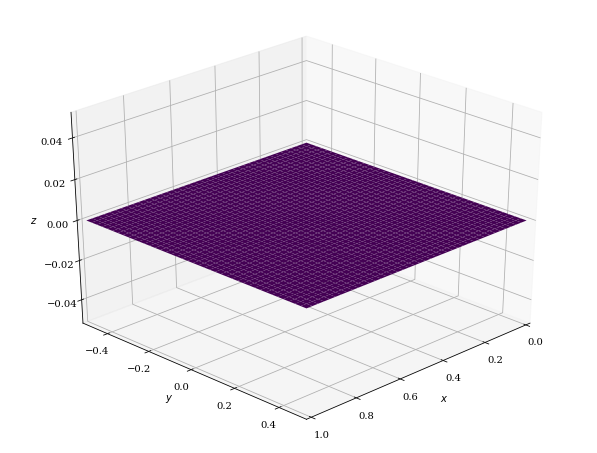

In [7]:
# Initial Conditions
p0 = np.zeros((ny, nx))

# Compute the source term
b = poisson_source(x, y, Lx, Ly)

# plot of the initial scalar field
plot_3d(x, y, p0)

Zeros everywhere and boundaries held at zero.

Let's run our relaxation scheme and see what effect the forcing function has on `p`.

In [8]:
# Solution using Jacobi relaxation method
p, ites, conv = poisson_2d_jacobi(p0, b, dx, dy, rtol = 2e-7)
print('Jacobi Relexation: {} iterations '.format(ites) +
     ' to reach a relative difference of {}'.format(conv[-1]))

Jacobi Relexation: 3125 iterations  to reach a relative difference of 1.9958631078740742e-07


It took 3125 iterations to converge to the exit criterion.

Let's take a look at the plot of the final field.

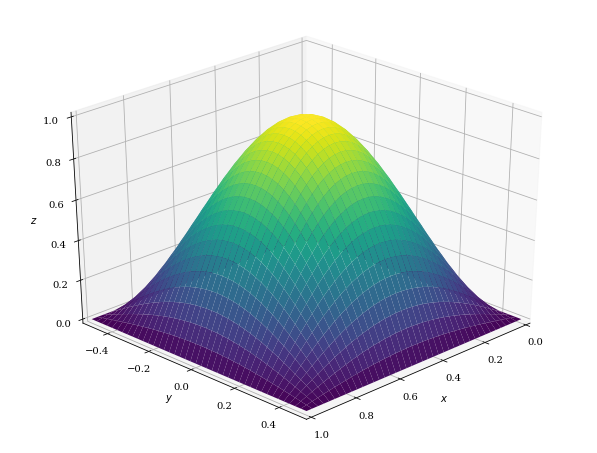

In [9]:
# Plot of the solution
plot_3d(x, y, p)

This problem has the following analytical solution:

$$
\begin{equation}
p(x,y) = \sin{\left(\frac{x\pi}{L_x} \right)}\cos{\left(\frac{y\pi}{L_y} \right)}
\end{equation}
$$


Let's compare the calculated solution to the analytical solution.

In [10]:
'''
    Computes and returns the analytical solution of the Poisson 
        equation on a given two - dimensional Cartesian grid.
        
    x : np.ndarray, gridline locations in the x direction as a
                1D array of floats
    y : np.ndarray, gridline locations in the y direction as a
                1D array of floats
    Lx : float, length of the domain in the x direction
    Ly : float, length of the domain in the y direction
    
    Returns:
    p : np.ndarray, analytical solution as a 2D array of floats
'''

def poisson_solution(x, y, Lx, Ly):
    X, Y = np.meshgrid(x, y)
    p = np.sin(np.pi * X / Lx) * np.cos(np.pi * Y / Ly)
    return p

In [11]:
# Analytical Solution
p_exact = poisson_solution(x, y, Lx, Ly)

In [12]:
# Relative L2 - norm of the error
l2_norm(p, p_exact)

0.00044962635351968803

### Algebraic Convergence

Remember that we saved the L2-norm of the difference between two consecutive iterations. The purpose of that was to look at how the relaxation scheme *converges*, in algebraic sense: with consecutive solutions getting closer and closer to each other. Let's use a line plot for this.

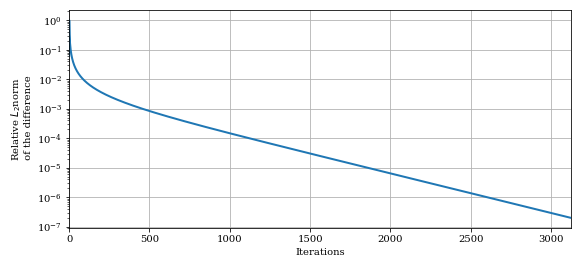

In [13]:
# Plot of the convergence history
py.figure(figsize = (9.0, 4.0))
py.xlabel('Iterations')
py.ylabel('Relative $L_2$norm \n of the difference')
py.grid()
py.semilogy(conv, color = 'C0', linestyle = '-', linewidth =2)
py.xlim(0, len(conv));

In the beginning, iterations started converging pretty fast. But they quickly adoped a slower rate.

It took more than 3000 iterations to get our difference between two consecutive solutions (in L2 norm).

### Spatial Convergence
Let's check that the solution is achieving the expected second -order convergence in space.

In [14]:
# List of the grid sie to investigate
nx_values = [11, 21, 41, 81]

# Empty list to record the error on each grid
errors = []

# Solution and error for each grid size
for nx in nx_values:
    ny = nx  # same number of points in all directions
    dx = Lx / (nx - 1)  # grid spacing in the x direction
    dy = Ly / (ny - 1)  # grid spacing in the y direction
    
    # Gridline locations.
    x = np.linspace(xmin, xmax, num = nx)
    y = np.linspace(ymin, ymax, num = ny)
    
    # Initial Conditions
    p0 = np.zeros((ny, nx))
    
    # Source term
    b = poisson_source(x, y, Lx, Ly)
    
    # Relax the solution
    # We do not return the number of iterations
    # or the convergence history
    p, ites, _ = poisson_2d_jacobi(p0, b, dx, dy, rtol = 2e-7)
    print('[nx = {}] Number of Jacobi iterations: {}'.format(nx, ites))
    
    # Analytical Solution
    p_exact = poisson_solution(x, y, Lx, Ly)
    
    # Compute and record the relative L2 - norm of the error
    errors.append(l2_norm(p, p_exact))

[nx = 11] Number of Jacobi iterations: 249
[nx = 21] Number of Jacobi iterations: 892
[nx = 41] Number of Jacobi iterations: 3125
[nx = 81] Number of Jacobi iterations: 10708


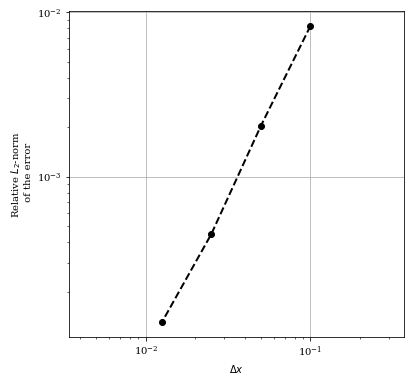

In [15]:
# Plot of the error versus the grid-spacing size
py.figure(figsize = (6.0, 6.0))
py.xlabel(r'$\Delta x$')
py.ylabel('Relative $L_2$-norm \n of the error')
py.grid()
dx_values = Lx / (np.array(nx_values) - 1)
py.loglog(dx_values, errors, color = 'black', linestyle = '--',
             linewidth = 2, marker = 'o')
py.axis('equal');

Yes, 2nd - order

Remember that the boundary conditions can adversely affect convergence, but Dirichlet boundaries are "exact" and will never impact convergence.

## Final Word

We have used the difference between two consecutive solutions in the iterative process as a way to indicate convergence. However, this is *not* in general the best idea. For some problems and some iterative methods, you could experience iterates *stagnating* but the solution *not converging*.

Convergence of an iterative solution of a system $A \mathbf{x} = \mathbf{b}$ means that:

$$
\begin{equation}
\lim_{k \rightarrow \infty} \mathbf{x}^k = \mathbf{x}
\end{equation}
$$

The error in the solution is actually $\mathbf{x}-\mathbf{x}^k$, but we're looking at $\mathbf{x}^{k+1}-\mathbf{x}^k$ for our exit criterion. They are not the same thing and the second could tend to zero (or machine precision) without the first being comparably small.